In [1]:
%matplotlib inline
import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import deque
from IPython import display
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
from training_methods import *
%load_ext autoreload
%autoreload

In [2]:
env = gym.make('CartPole-v1')
env.my_preprocess_input = lambda x: x

print('Observation space {}, Actions: {}, {} parameters'.format(
    env.action_space.n, env.observation_space.shape, np.prod(env.observation_space.shape)))

run_name = 0

[2017-08-07 18:20:50,854] Making new env: CartPole-v1


Observation space 2, Actions: (4,), 4 parameters


In [69]:
class DqnSiameseEmbeddingAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.embedding_size = 3
        self.action_zeros = np.zeros(self.params.action_size)
        self._build_oracle_model()
        self._build_dqn_model()

    def _build_dqn_model(self):
        self.dqn_x = tf.placeholder(tf.float32, [None, self.embedding_size], name='dqn_x')
        self.dqn_y = tf.placeholder(tf.float32, [None, self.params.action_size], name='dqn_y')
        
        w0 = tf.Variable(tf.random_normal([self.embedding_size, 12]))
        b0 = tf.Variable(tf.random_normal([12]))
        w1 = tf.Variable(tf.random_normal([12, self.params.action_size]))
        b1 = tf.Variable(tf.random_normal([self.params.action_size]))
        
        h0 = tf.add(tf.matmul(self.dqn_x, w0), b0)
        h0 = tf.nn.relu(h0)
        
        self.dqn_pred = tf.add(tf.matmul(h0, w1), b1)
        
        cost = tf.nn.l2_loss(self.dqn_pred - self.dqn_y, name='dqn_cost')
        self.dqn_train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
            .minimize(cost)
        
    def _build_oracle_model(self):
        input_size = self.params.state_size + self.params.action_size
        self.oracle_x0 = tf.placeholder(tf.float32, [None, input_size], name='orc_x0')
        self.oracle_x1 = tf.placeholder(tf.float32, [None, input_size], name='orc_x1')
        self.oracle_y = tf.placeholder(tf.float32, [None, 1], name='orc_y')

        with tf.variable_scope('seamese') as scope:
            self.oracle_o1 = self._build_oracle_L(self.oracle_x0, 12, self.embedding_size)
            scope.reuse_variables()
            self.oracle_o2 = self._build_oracle_L(self.oracle_x1, 12, self.embedding_size)

        distance = tf.reduce_sum(tf.pow(self.oracle_o1 - self.oracle_o2, 2), 1, keep_dims=True, name='distance')

        # if Y == 0 => min distance
        # if Y == 1 => max distance
        pos = (1 - self.oracle_y) * distance
        neg = self.oracle_y * tf.maximum((1 - distance), 0)
        self.oracle_loss = tf.reduce_sum(pos + neg, name='orc_loss')

        self.oracle_train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
            .minimize(self.oracle_loss)
            
        with tf.name_scope('summaries'):
            tf.summary.scalar('oracle_loss', self.oracle_loss)
            tf.summary.scalar('pos_avg_distance', tf.reduce_mean(pos))
            tf.summary.scalar('neg_avg_distance', tf.reduce_mean(self.oracle_y * distance))
        self.merged_summaries = tf.summary.merge_all()
    
    def _build_oracle_L(self, x, hidden_size, out_size):
        fc1 = self._build_fully_connected_layer(x, hidden_size, 'fc1')
        fc2 = self._build_fully_connected_layer(tf.nn.relu(fc1), out_size, 'fc2')
        return fc2
    
    def _build_fully_connected_layer(self, bottom, size, name):
        bottom_size = bottom.get_shape()[1]
        initer = tf.truncated_normal_initializer(stddev=0.01)
        w0 = tf.get_variable(name + 'w0', shape=[bottom_size, size], initializer=initer)
        b0 = tf.get_variable(name + 'b0', initializer=tf.random_normal([size]))
        fc = tf.add(tf.matmul(bottom, w0), b0)
        return fc
    
    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        oracle_input = np.concatenate([state, self.action_zeros], axis=0)
        embedding = session.run(self.oracle_o1, {self.oracle_x0: [oracle_input]})
        act_values = session.run(self.dqn_pred, {self.dqn_x: embedding})[0]
        return np.argmax(act_values)

    def think(self, batch_size, episode):
#         if episode < 200:
        self.think_oracle(batch_size, episode)
        self.think_dqn(batch_size, episode)
        
    def think_dqn(self, batch_size, episode):
        x = self.dqn_x
        y = self.dqn_y
        train_op = self.dqn_train_op
        
        cnt = len(self.memory)
        X = np.zeros((cnt, self.embedding_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            
            oracle_input = np.concatenate([state, self.action_zeros], axis=0)
            embedding_state = session.run(self.oracle_o1, {self.oracle_x0: [oracle_input]})
            
            oracle_input = np.concatenate([next_state, self.action_zeros], axis=0)
            embedding_next_state = session.run(self.oracle_o1, {self.oracle_x0: [oracle_input]})
            next_state_values = session.run(self.dqn_pred, {x: embedding_next_state})[0]
            
            target = session.run(self.dqn_pred, {x: embedding_state})[0]
            target[action] = reward + self.params.gamma * \
                             np.amax(next_state_values)
            
#             print(embedding_state)
#             print(embedding_next_state)
#             print(next_state_values)
#             print(target)
#             raise Hi
            
            X[i], Y[i] = embedding_state[0], target

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            batch_x = X[batch_indexes]
            batch_y = Y[batch_indexes]
            _ = session.run(self.dqn_train_op, {x: batch_x, y: batch_y})
        
    def think_oracle(self, batch_size, episode):
        x0 = self.oracle_x0
        x1 = self.oracle_x1
        y = self.oracle_y
        
        cnt = len(self.memory)
        X0 = np.zeros((2 * cnt, self.params.state_size + self.params.action_size))
        X1 = np.zeros((2 * cnt, self.params.state_size + self.params.action_size))
        Y = np.zeros((2 * cnt, 1))
        action_ohe = np.zeros(self.params.action_size)
        prev_state = np.concatenate([self.memory[np.random.randint(cnt)][0], self.action_zeros], axis=0)
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            action_ohe[action] = 1.0
            input_x = np.concatenate([state, action_ohe], axis=0)
            input_pos = np.concatenate([next_state, self.action_zeros], axis=0)
            input_neg = prev_state
            j = i + cnt
            X0[i], X1[i], Y[i] = input_x, input_pos, 0.0
            X0[j], X1[j], Y[j] = input_x, input_neg, 1.0
            action_ohe[action] = 0.0
            prev_state = np.concatenate([state, self.action_zeros], axis=0)
            
        P = np.random.permutation(Y.shape[0])
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            batch_x0 = X0[batch_indexes]
            batch_x1 = X1[batch_indexes]
            batch_y = Y[batch_indexes]
            _ = session.run(self.oracle_train_op, {x0: batch_x0, x1: batch_x1, y: batch_y})
        
        summary = session.run(self.merged_summaries, {x0: X0, x1: X1, y: Y})
        tf_writer.add_summary(summary, episode)

State shape (4,), actions 2
Run: 15
episode: 50/1000, reward 22.8, frames 12, exploration rate: 0.87
episode: 100/1000, reward 21.4, frames 16, exploration rate: 0.75
episode: 150/1000, reward 20.5, frames 34, exploration rate: 0.64
episode: 200/1000, reward 13.6, frames 15, exploration rate: 0.55
episode: 250/1000, reward 14.0, frames 10, exploration rate: 0.48
episode: 300/1000, reward 13.9, frames 10, exploration rate: 0.41
episode: 350/1000, reward 12.1, frames 12, exploration rate: 0.35
episode: 400/1000, reward 11.0, frames 8, exploration rate: 0.3
episode: 450/1000, reward 11.1, frames 9, exploration rate: 0.26
episode: 500/1000, reward 10.5, frames 14, exploration rate: 0.22
episode: 550/1000, reward 9.3, frames 9, exploration rate: 0.19
episode: 600/1000, reward 10.3, frames 7, exploration rate: 0.17
episode: 650/1000, reward 9.9, frames 8, exploration rate: 0.14
episode: 700/1000, reward 9.8, frames 7, exploration rate: 0.12
episode: 750/1000, reward 10.4, frames 9, explorati

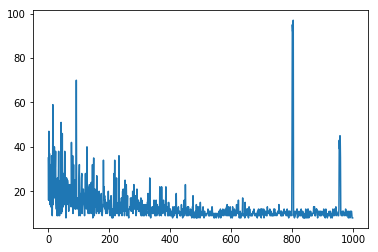

In [70]:
params = LearningParameters(env, episodes_count=1000)
params.max_frame_in_episode = min(params.max_frame_in_episode, 10000)
params.episodes_between_think = 5
params.epsilon_min = 0.05
params.earning_rate = 0.01

if 'session' in locals():
    session.close()
    tf_writer.close()
tf.reset_default_graph()    
config = tf.ConfigProto(device_count = {'GPU': 0})
session = tf.Session(config=config)
run_name += 1
print('Run: ' + str(run_name))

agent = DqnSiameseEmbeddingAgent(params)

tf_writer = tf.summary.FileWriter('logs/run' + str(run_name), session.graph)

session.run(tf.global_variables_initializer())

agent, rewards = train_discounted_rewards(env, agent, params, normalize_rewards=True)
# agent, rewards = train_reward_is_time(env, agent, params)
# agent, rewards = train(env, agent, params)
plt.plot(rewards)

In [58]:
evaluate(env, agent, params, 500)

Total reward: 10.0
